In [1]:
!pip install huggingface_hub transformers timm

  Obtaining dependency information for huggingface_hub from https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688bc2d36b3a47d2/huggingface_hub-0.16.4-py3-none-any.whl.metadata
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.3 MB/s eta 0:00:00
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("../extraction_core/page_selection")
sys.path.append("../extraction_core/extraction")
sys.path.append("../extraction_core/")

In [4]:
import hvac
import os
client = hvac.Client(
    url="https://vault.lab.sspcloud.fr", token=os.environ["VAULT_TOKEN"]
)

secret = os.environ["VAULT_MOUNT"] + os.environ["VAULT_TOP_DIR"] + "/s3_creds"
mount_point, secret_path = secret.split("/", 1)
secret_dict = client.secrets.kv.read_secret_version(
    path=secret_path, mount_point=mount_point
)

os.environ["AWS_ACCESS_KEY_ID"] = secret_dict["data"]["data"][
    "ACCESS_KEY"
]
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict["data"]["data"][
    "SECRET_KEY"
]
try:
    del os.environ["AWS_SESSION_TOKEN"]
except KeyError:
    pass

In [5]:
from extraction.data import fs

fs.ls("projet-extraction-tableaux/orange/bmp")

['projet-extraction-tableaux/orange/bmp/306769688.bmp',
 'projet-extraction-tableaux/orange/bmp/307299248.bmp',
 'projet-extraction-tableaux/orange/bmp/345039416.bmp',
 'projet-extraction-tableaux/orange/bmp/379984891.bmp',
 'projet-extraction-tableaux/orange/bmp/380129866.bmp',
 'projet-extraction-tableaux/orange/bmp/384518114.bmp',
 'projet-extraction-tableaux/orange/bmp/409759156.bmp',
 'projet-extraction-tableaux/orange/bmp/430107359.bmp',
 'projet-extraction-tableaux/orange/bmp/432668432.bmp',
 'projet-extraction-tableaux/orange/bmp/440419240.bmp',
 'projet-extraction-tableaux/orange/bmp/500413505.bmp',
 'projet-extraction-tableaux/orange/bmp/500440813.bmp',
 'projet-extraction-tableaux/orange/bmp/501614572.bmp']

In [6]:
from pathlib import Path

for path in fs.ls("projet-extraction-tableaux/orange/bmp"):
    file_name = Path(path).stem
    fs.get(path, "../data/orange/" + file_name + ".bmp")

In [7]:
for path in fs.ls("projet-extraction-tableaux/orange/bmp"):
    file_name = Path(path).stem
    print(file_name)

306769688
307299248
345039416
379984891
380129866
384518114
409759156
430107359
432668432
440419240
500413505
500440813
501614572


In [4]:
from pathlib import Path
from PIL import Image
from huggingface_hub import hf_hub_download
from transformers import DetrFeatureExtractor, DetrImageProcessor
from transformers import TableTransformerForObjectDetection
import torch
import pytesseract
from pytesseract import Output
from extraction.table_transformer_utils import *
from io import StringIO
import pandas as pd
from extraction.utils import get_root_path
from extraction.image_utils import *
import matplotlib.pyplot as plt

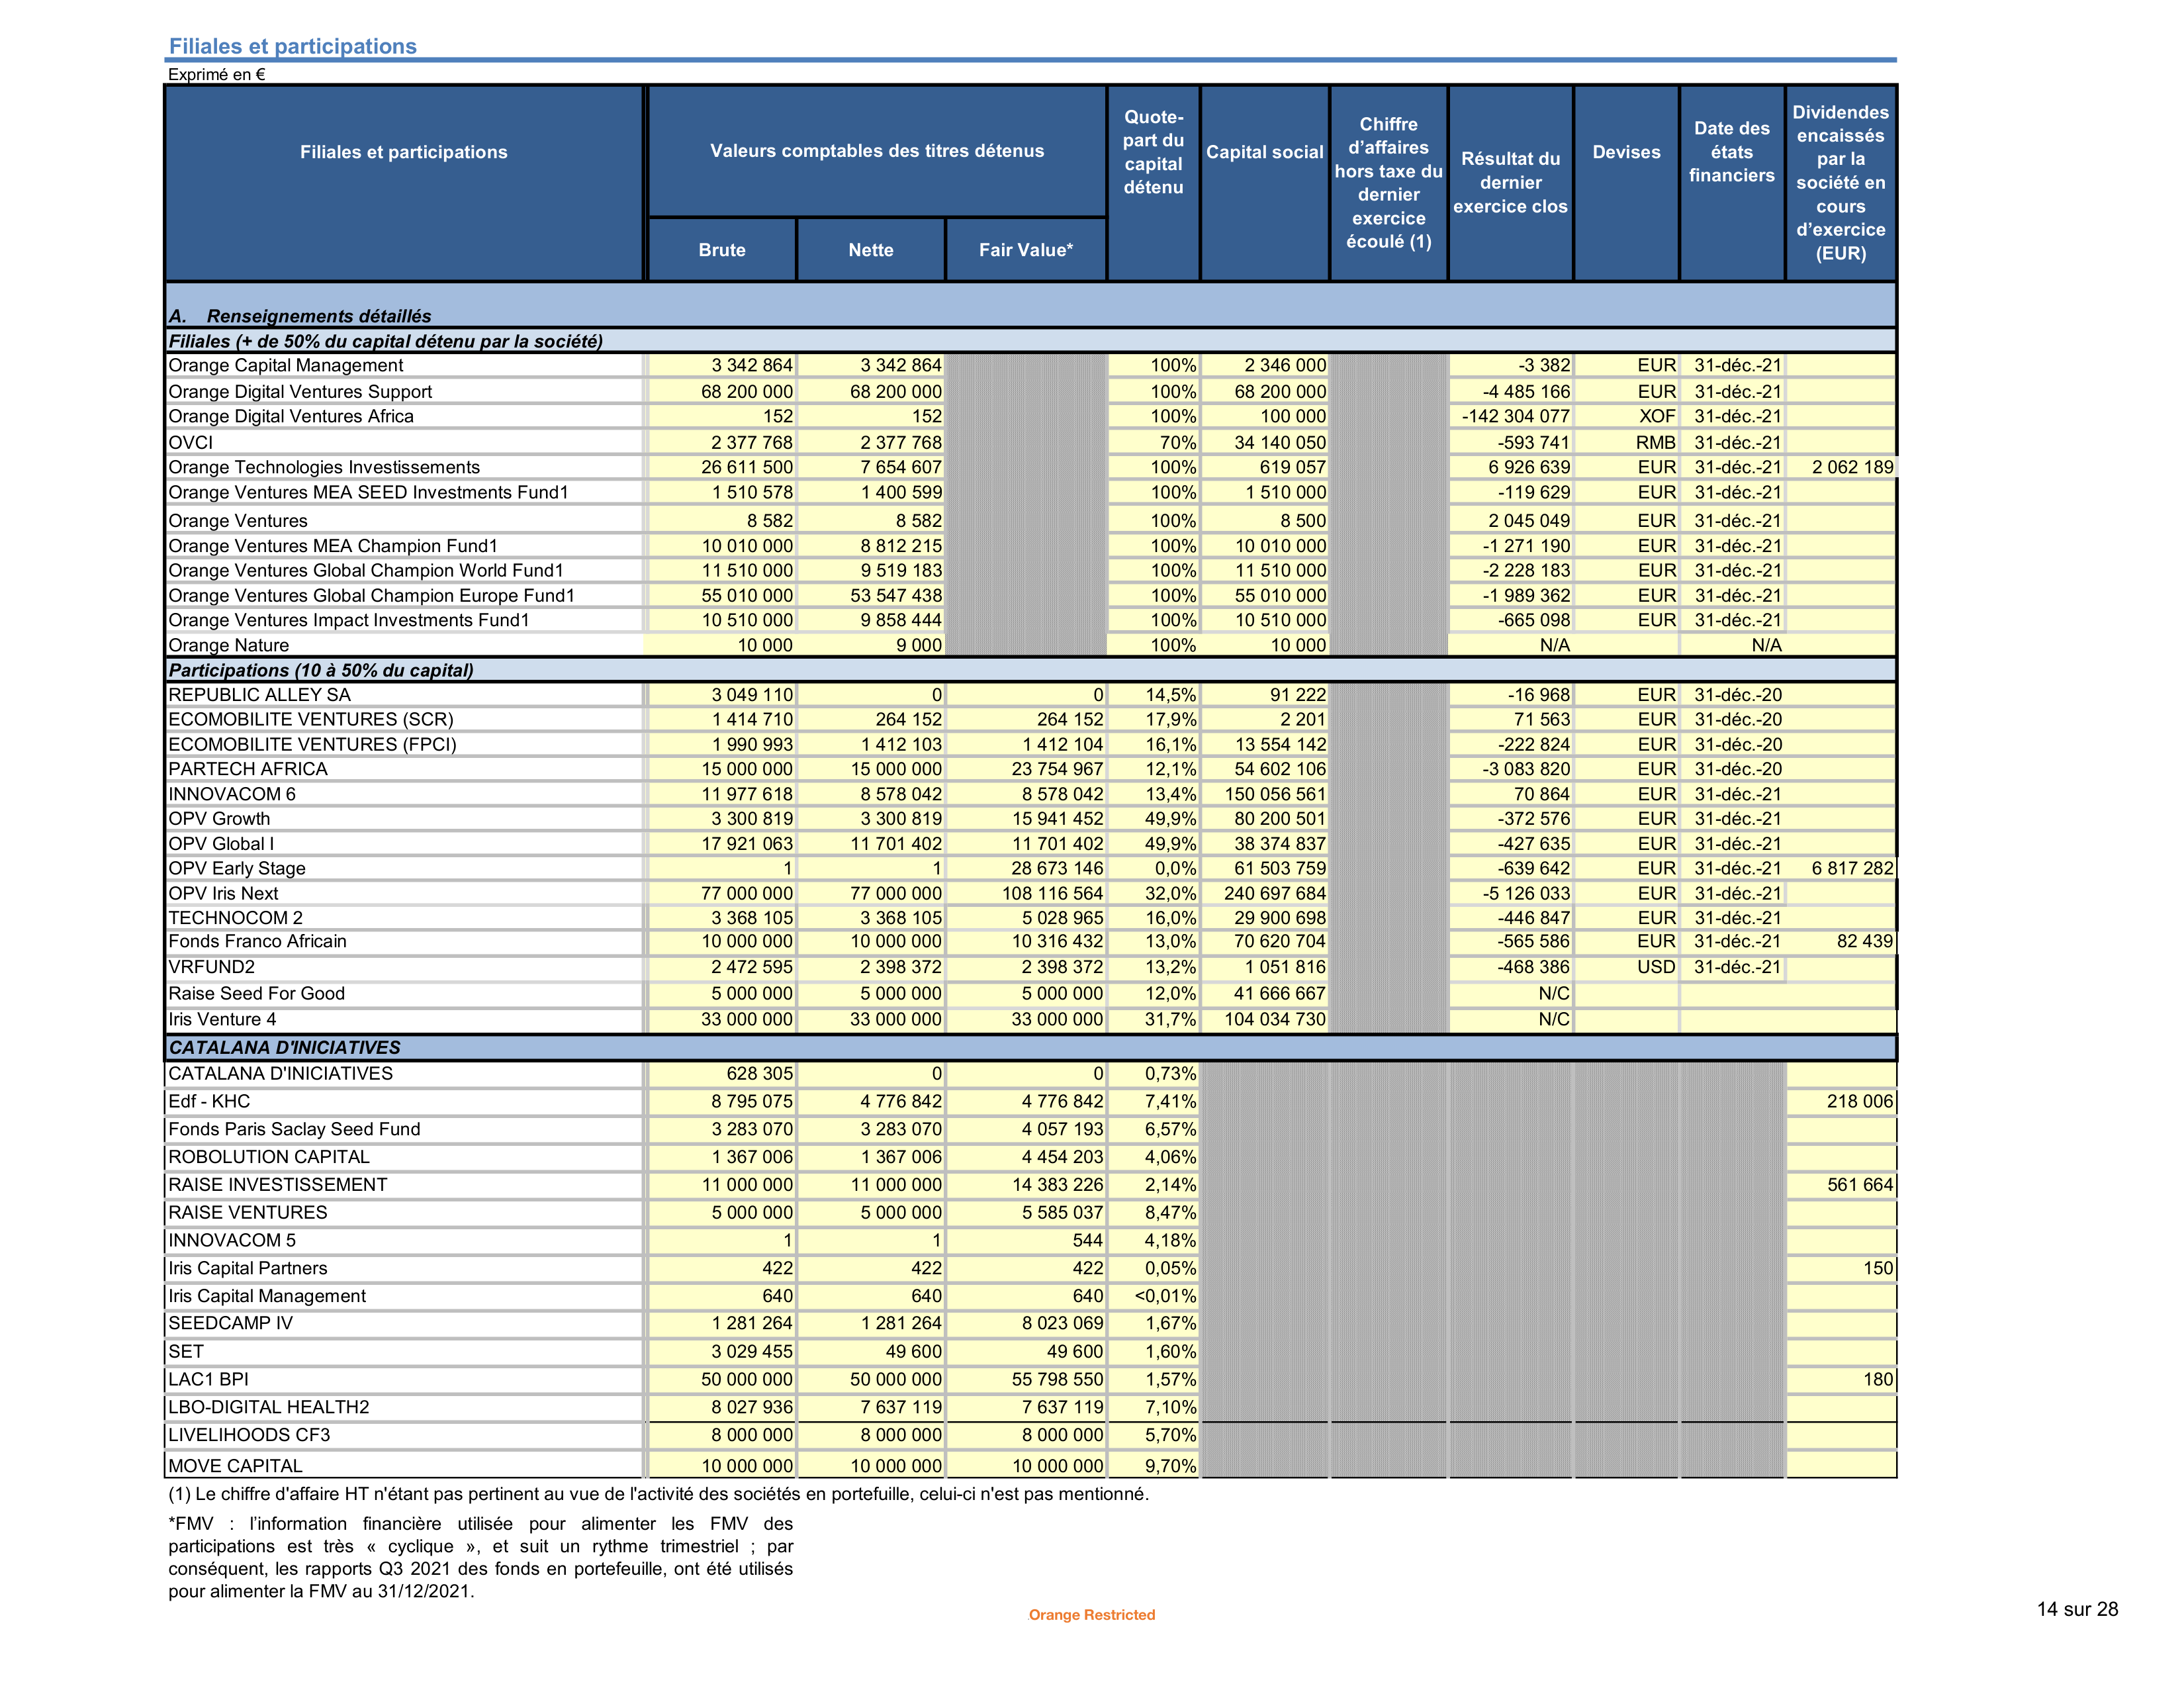

In [13]:
data_dir = "../data/orange"
image_path = Path(data_dir).joinpath("306769688.bmp")
image = Image.open(image_path)

#image = to_bw(image)

threshold_area = 1e-3
thresh = threshold_otsu(
    np.expand_dims(np.array(image.convert("L")), axis=-1)
)
bw = np.expand_dims(np.array(image.convert("L")), axis=-1) > thresh
cs, _ = cv2.findContours(
    np.invert(bw).astype("uint8"),
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE,
)

# set up filled_image
filled_image = np.zeros(bw.shape[0:2]).astype("uint8")
image_area = bw.shape[0] * bw.shape[1]

dark_areas_dummy = False
for i, c in enumerate(cs):
    m = cv2.moments(c)
    area = m["m00"]

    if area / image_area > threshold_area:
        selected_contour = cv2.drawContours(
            filled_image, cs, i, color=255, thickness=-1
        )
        dark_areas_dummy = True

if not dark_areas_dummy:
    image = image

mask = selected_contour == 255
segmented_mask = label(mask)
filtered_mask = np.zeros_like(mask)
for i in np.unique(segmented_mask)[1:]:
    contour = np.where(segmented_mask == i, 1, 0)
    crop = bw[np.ix_(contour.any(1), contour.any(0))]
    if (
        len(crop[crop == 0])
        / (len(crop[crop == 0]) + len(crop[crop == 1]))
    ) > 0.5:
        filtered_mask = np.maximum(filtered_mask, contour)

# modified_image = bw * (1 - np.expand_dims(filtered_mask, -1)) \
#   + np.invert(bw) * np.expand_dims(filtered_mask, -1)
modified_image = image * (
    1 - np.expand_dims(filtered_mask, -1)
) + np.invert(image) * np.expand_dims(filtered_mask, -1)

Image.fromarray(np.uint8(modified_image)).convert("RGB")

In [18]:
img_bgr = cv2.imread("../data/orange/306769688.bmp")  # Read image as BGR

img_grey = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # Convert from BGR to grayscale.

thresh = 170
img_binary_inv = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY_INV)[1]  # Apply threshold and invert black/white

# Convert from BGR to HSV color space.
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Get the saturation color channel - all black and white are zero, and colored pixels are above zero.
s = hsv[:, :, 1]

thresh = 100
s_binary = cv2.threshold(s, thresh, 255, cv2.THRESH_BINARY)[1]  # Apply threshold to the saturation channel.

# Find contours on s_binary
cnts = cv2.findContours(s_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]  # Use index [-2] to be compatible to OpenCV 3 and 4

# Draw the contours as white (255 values) on black background.
mask = np.zeros_like(s_binary)
cv2.drawContours(mask, cnts, -1, 255, -1)

# Apply morphological closing for closing some black gaps.
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3)))

# Get only the area inside the mask from img_binary_inv
masked_binary_inv = cv2.bitwise_or(img_binary_inv, img_binary_inv, mask=mask)

# Copy masked_binary_inv to img_grey only in pixels that mask is white.
cv2.copyTo(masked_binary_inv, mask, img_grey)

#cv2.imshow('img_bgr', img_bgr)

cv2.imwrite('../data/orange/306769688.png', img_grey)  # Save result (as PNG and not JPEG for better quality).

# Show images
#cv2.imshow('img_bgr', img_bgr)
#cv2.imshow('s_binary', s_binary)
#cv2.imshow('mask', mask)
#cv2.imshow('masked_binary_inv', masked_binary_inv)
#cv2.imshow('img_grey', img_grey)
#cv2.waitKey()
#cv2.destroyAllWindows()

True

In [26]:
TEST_DATA = [
    "306769688",
    #"345039416",
    #"380129866",
    #"384518114",
    #"409759156",
    #"432668432",
    #"440419240",
    #"500413505",
    #"307299248",
    #"379984891",
    #"430107359",
    #"500440813",
    #"501614572",
]
data_dir = "../data/orange"
test_images = [
    Path(data_dir).joinpath(path + ".png") for path in TEST_DATA
]

feature_extractor = DetrImageProcessor()
detection_model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection"
)
structure_model = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition"
)

# Paddings
left_padding = 20
top_padding = 50
right_padding = 20
bottom_padding = 50

# Dict
output = {}
check = []

for siren, image_path in zip(TEST_DATA, test_images):
    print(f"--- Siren {siren} ---")
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    # Encoding for table detection
    encoding = feature_extractor(image, return_tensors="pt")
    with torch.no_grad():
        outputs = detection_model(**encoding)
    results = feature_extractor.post_process_object_detection(
        outputs, threshold=0.7, target_sizes=[(height, width)]
    )[0]
    table_boxes = results["boxes"].tolist()

    for table_idx, table_box in enumerate(table_boxes):
        print(f"--- Table {table_idx} ---")
        xmin, ymin, xmax, ymax = table_box
        # Cropped image (only detected table)
        resized_image = image.crop(
            (
                xmin - right_padding,
                ymin - top_padding,
                xmax + right_padding,
                ymax + bottom_padding,
            )
        )

        # Encoding for structure recognition
        encoding = feature_extractor(resized_image, return_tensors="pt")
        with torch.no_grad():
            outputs = structure_model(**encoding)

        target_sizes = [resized_image.size[::-1]]
        results = feature_extractor.post_process_object_detection(
            outputs, threshold=0.6, target_sizes=target_sizes
        )[0]

        # Getting tokens
        d = pytesseract.image_to_data(
            resized_image, output_type=Output.DICT
        )
        tokens = []
        n_boxes = len(d["level"])
        for i in range(n_boxes):
            (xmin, ymin, w, h) = (
                d["left"][i],
                d["top"][i],
                d["width"][i],
                d["height"][i],
            )
            xmax = xmin + w
            ymax = ymin + h
            text = d["text"][i]
            tokens.append({"bbox": [xmin, ymin, xmax, ymax], "text": text})
        # 'tokens' is a list of tokens
        # Need to be in a relative reading order
        # If no order is provided, use current order
        for idx, token in enumerate(tokens):
            if not "span_num" in token:
                token["span_num"] = idx
            if not "line_num" in token:
                token["line_num"] = 0
            if not "block_num" in token:
                token["block_num"] = 0

        # Post-process detected objects, assign class labels
        objects = results_to_objects(
            results, resized_image.size, str_class_idx2name
        )

        check.append(tokens)

        # Further process the detected objects so they correspond to a consistent table
        tables_structure = objects_to_structures(
            objects, tokens, structure_class_thresholds
        )

        # Enumerate all table cells: grid cells and spanning cells
        table_cells = [
            structure_to_cells(structure, tokens)[0]
            for structure in tables_structure
        ]

        table_csvs = [cells_to_csv(cells) for cells in table_cells]

        io = StringIO(table_csvs[0])
        df = pd.read_csv(io, sep=",")

        output[f'{siren}_{table_idx}'] = df

--- Siren 306769688 ---
--- Table 0 ---


In [27]:
result = output.copy()

In [29]:
result['306769688_0']

,Filiales et participations,Valeurs comptables des titres détenus |,Valeurs comptables des titres détenus | .1,Valeurs comptables des titres détenus | Fair Value*,Quote- part du capital détenu,Capital social] |,Chiffre “affaires | hors taxe du dernier exercice écoulé (1),52. atau | dernier exercice clos,Devises,Date des états financiers,Dividendes encaissés par la société en cours d’exercice (EUR)
0,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés,A. Renseignements détaillés
1,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...,Filiales (+ de 50% du capital détenu par la so...
2,Orange Capital Management,3 342 864,3 342 864,NaN,100%,2 346 000,NaN,-3 382,EUR,31-déc.-21,NaN
3,Orange Digital Ventures Support,68 200 000,68 200 000,NaN,100%,68 200 000,NaN,-4 485 166,EUR,31-déc.-21,NaN
4,Orange Digital Ventures Africa,152,152,NaN,100%,100 000,NaN,-142 304 077,XOF,31-déc.-21,NaN
5,OVCI,2 377 768,2 377 768,NaN,70%,34 140 050,NaN,-593 741,RMB_,31-déc.-21,NaN
6,Orange Technologies Investissements,26 611 500,7 654 607,NaN,100%,619 057,NaN,6 926 639,EUR,31-déc.-21,2062 189
7,Orange Ventures MEA SEED Investments Fund1,1 510 578,1 400 599,NaN,100%,1 510 000,NaN,-119 629,EUR,31-déc.-21,NaN
8,Orange Ventures,8 582,8 582,NaN,100%,8 500,NaN,2 045 049,EUR,31-déc.-21,NaN
9,Orange Ventures MEA Champion Fund1,10 010 000,8 812 215,NaN,100%,10 010 000,NaN,-1 271 190,EUR,31-déc.-21,NaN
